In [1]:
# импортируем библиотеки для работы с данными
import pandas as pd
from sklearn import preprocessing 
# Импортируем DBSCAN-кластеризацию, алгомеративную кластеризацию из sklearn
from sklearn.cluster import DBSCAN , AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.metrics.cluster import completeness_score
# импортируем библиотеку scipy, чтобы визуализировать дендрограмму
from scipy.cluster.hierarchy import dendrogram, linkage
# графика
import plotly
import plotly.express as px
import seaborn as sns
from matplotlib import pyplot as plt

In [33]:
# напишем функцию, которая будет выводить графики
def get_3d_visualization(df, clust_res=None):
    fig = px.scatter_3d(
        data_frame=df, 
        x = 'age', 
        y = 'annual_income', 
        z = 'spending_score', 
        color = clust_res,
        width=1000,
        height=700
    )
    #возвращаем график
    return fig

In [34]:
# напишем функцию, которая будет проводить алгомеративную кластеризацию
# на вход она будет принимать X — матрицу с признаками для кластеризации и n_clusters — количество кластеров,
# на выходе будет возвращать список с номерами кластеров
def get_aggl_clustering(X, n_clusters):
    # запустим агломеративную кластеризацию
    agglomerative_clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    # обучим модель агломеративной кластеризации
    agglomerative_clustering.fit(X)
    # получим список c информацией, к какому кластеру относятся объекты
    aggl_prediction = agglomerative_clustering.labels_
    # вернём список с результатами
    return aggl_prediction

In [51]:
# напишем функцию для подсчёта коэффициента силуэта
def get_silhouette_agg_clust(X, cluster_num):
    # проведём агломеративную кластеризацию с заданным количеством кластеров
    res = get_aggl_clustering(X, cluster_num)
    # рассчитаем коэффициент силуэта
    silhouette = silhouette_score(X, res)
    return silhouette

In [2]:
# загрузим данные
df = pd.read_csv("../../data/segmented_customers.csv")
# посмотрим на данные
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),cluster
0,1,Male,19.0,15.0,39.0,4.0
1,2,Male,21.0,15.0,81.0,3.0
2,3,Female,20.0,16.0,6.0,4.0
3,4,Female,23.0,16.0,77.0,3.0
4,5,Female,31.0,17.0,40.0,4.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   CustomerID              205 non-null    int64  
 1   Gender                  205 non-null    object 
 2   Age                     203 non-null    float64
 3   Annual Income (k$)      203 non-null    float64
 4   Spending Score (1-100)  204 non-null    float64
 5   cluster                 201 non-null    float64
dtypes: float64(4), int64(1), object(1)
memory usage: 9.7+ KB


In [4]:
df.isnull().sum()

CustomerID                0
Gender                    0
Age                       2
Annual Income (k$)        2
Spending Score (1-100)    1
cluster                   4
dtype: int64

In [5]:
# посмотрим, есть ли пропуски в датасете
df[df.isna().any(axis=1)]

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),cluster
200,201,Female,21.0,NaN,40.0,0.0
201,202,Female,30.0,127.0,NaN,NaN
202,203,Male,80.0,NaN,20.0,NaN
203,204,Male,NaN,16.0,120.0,NaN
204,205,Female,NaN,9.0,80.0,NaN


In [16]:
proc_1=df[df.isna().any(axis=1)].shape[0]
proc_0=df.shape[0]
print('Мы потеряем {:.2f}% данных'.format(100/proc_0*proc_1))

Мы потеряем 2.44% данных


In [17]:
# пропусков не так много, поэтому мы можем удалить данные с пропусками
df = df.dropna()

# переименуем столбцы для более удобной работы
df.rename(columns = {'CustomerID' : 'customer_id', 'Gender' : 'gender', 
                    'Age': 'age', 'Annual Income (k$)': 'annual_income', 
                    'Spending Score (1-100)': 'spending_score', }, inplace = True)

In [18]:
# проверим, есть ли в данных дубликаты
df[df.duplicated(subset=['customer_id'])]

,customer_id,gender,age,annual_income,spending_score,cluster


In [35]:
get_3d_visualization(df)

In [28]:
X = df[['age', 'annual_income', 'spending_score']]

### Задание 10.1
Попробуйте провести DBSCAN-кластеризацию со значениями по умолчанию. Сколько кластеров у вас получилось?

In [36]:
# Запускаем кластеризацию на наших данных
clustering = DBSCAN().fit(X)
print('найдено классов',pd.Series(clustering.labels_)[pd.Series(clustering.labels_)>-1].nunique())
print('найдено выдросов',pd.Series(clustering.labels_)[pd.Series(clustering.labels_)==-1].nunique())
# Далее можно визуализировать результаты
get_3d_visualization(X, clustering.labels_)

найдено классов 0
найдено выдросов 1


In [37]:
#запускаем кластеризацию на наших данных
dbscan = DBSCAN(eps=13,min_samples=7)
clustering_dbscan_res = dbscan.fit_predict(X)
df['dbscan_res_eps_11'] = clustering_dbscan_res
print('найдено классов',df['dbscan_res_eps_11'][df['dbscan_res_eps_11']>-1].nunique())
print('найдено выдросов',df['dbscan_res_eps_11'][df['dbscan_res_eps_11']==-1].nunique())
get_3d_visualization(df, 'dbscan_res_eps_11')

найдено классов 4
найдено выдросов 1


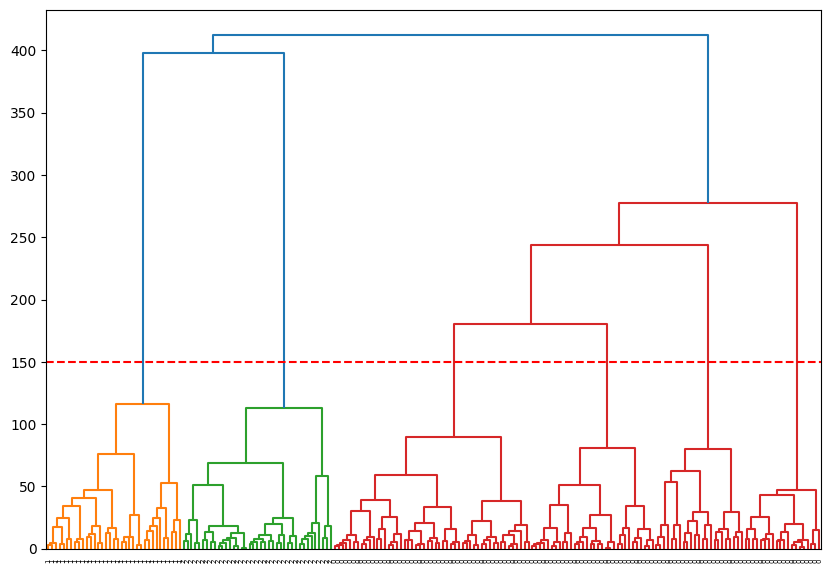

In [48]:
# запускаем агломеративную кластеризацию и сохраним результаты в df
df['aggl_res_3'] = get_aggl_clustering(X, 3)

linked = linkage(X, 'ward')
plt.figure(figsize=(10, 7))

dendrogram(linked,
            orientation='top',
            labels=df['aggl_res_3'].to_list(),
            distance_sort='descending',
            show_leaf_counts=True)
plt.axhline(y=150, color='r', linestyle='--')

plt.show()

In [49]:
df['aggl_res_6'] = get_aggl_clustering(X, 6)
display(df['aggl_res_6'].value_counts())
get_3d_visualization(df, 'aggl_res_6')

aggl_res_6
1    51
2    39
0    35
5    32
4    23
3    20
Name: count, dtype: int64

### Задание 10.4
Для агломеративной кластеризации самостоятельно с помощью коэффициента силуэта подберите оптимальное количество кластеров. Сколько кластеров у вас получилось?

<Axes: xlabel='cluster', ylabel='silhouette'>

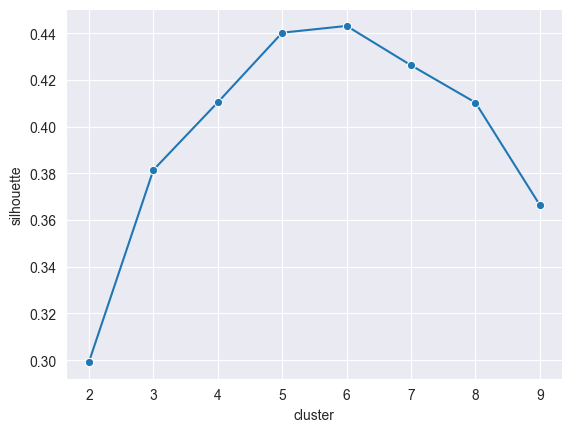

In [52]:
# создадим пустой словарь, ключами будут коэффициент силуэта и количество кластеров
silhouette_res = {"silhouette": [], "cluster": []}

for cluster_num in range(2, 10):
    silhouette_res["silhouette"].append(get_silhouette_agg_clust(X, cluster_num))
    silhouette_res["cluster"].append(cluster_num)

# сохраним в датафрейм значение силуэта и количество кластеров
silhouette_df = pd.DataFrame(silhouette_res)

# установим стиль для визуализиции
sns.set_style("darkgrid")
# визуализируем зависимость значения инерции от количества кластеров
sns.lineplot(data=silhouette_df, x="cluster", y="silhouette", marker="o")

In [53]:
print(completeness_score(labels_true=df.cluster, labels_pred=df.aggl_res_6))
# 0.9012847747610448

0.9012847747610448
